## PCA with linear models

As we saw during the EDA after PCA tranformation our target variable seemed to depend lineary of the principal components. Especially of the first principal component.

So the first assumption will be that we can receive good model by using PCA transformation with data clearing.

We have already cleared obvious outliers for this assumption in the EDA notebook and saved the rest data in **models/PCA_linear_regression/EDA_cleared.csv**.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib as mpl
import seaborn as sns
from IPython.core.display import HTML
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.linear_model import Ridge, Lasso, LinearRegression

In [2]:
data = pd.read_csv("data/train_without_nans.csv")
data_sub = pd.read_csv("data/test_without_nans.csv")

encoded = pd.read_csv("data/encoded_train.csv")
encoded_sub = pd.read_csv("data/encoded_test.csv")

cleared = pd.read_csv("models/PCA_linear_regression/EDA_cleared.csv")

## Content

## Data Transformation

Let's transform our train and submission data using PCA

In [3]:
continuous_columns = ['LotFrontage', 'LotArea', 'OverallQual', 
                      'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
                      'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                      '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
                      'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
                      'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
                      'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
                      'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
                      'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

'''
    Scaling the cleared train data and then sub 
    data based on the cleared data scaling parameters
'''
scaled = cleared.copy() 
scaled_sub = encoded_sub.copy()

scaler = StandardScaler()

scaled[continuous_columns] = scaler.fit_transform(scaled[continuous_columns])
scaled_sub[continuous_columns] = scaler.transform(scaled_sub[continuous_columns])

scaled["SalePrice"] = np.log(scaled["SalePrice"])

'''
    Transforming the scaled train data and then 
    scaled sub data based on the scaled train
    transformation parameters
'''

pca = PCA(n_components = 50, random_state=1)

reduced = scaled.drop(["SalePrice"], axis=1)
reduced = pd.DataFrame(pca.fit_transform(reduced),
                       columns=["pc{}".format(i) for i in range(1, 51)])
reduced["SalePrice"] = scaled["SalePrice"]

reduced_sub = pd.DataFrame(pca.transform(scaled_sub),
                           columns=["pc{}".format(i) for i in range(1, 51)])

In [4]:
reduced.shape, reduced_sub.shape

((1395, 51), (1459, 50))

## Visualization

To ensure that the transformation was made correctly and that we received something like in EDA

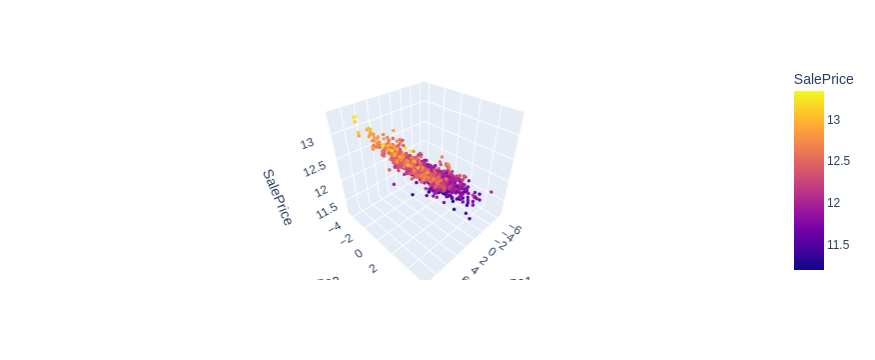

In [6]:
fig = px.scatter_3d(reduced, x="pc1", y="pc2", z="SalePrice", color="SalePrice")
fig.update_traces(marker_size = 2)
fig.show()

## PCA decorrelating effect

PCA has a very usefull property. Features, created by PCA are uncorrelated. That means that we can use simple Linear Regression for our data and don't be afraid that we can receive some large model coefficients because of the multicollinearity problem. We can ensure in this by taking corr() method in our reduced data

<Axes: >

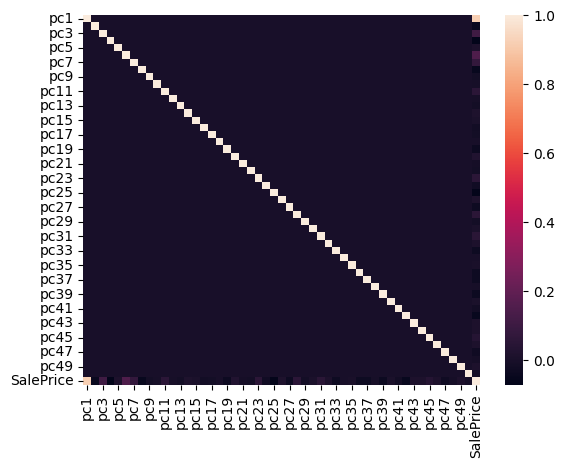

In [7]:
sns.heatmap(reduced.corr())

## Clearing objects with high residuals

As we said in the EDA we have some objects which look like outliers, but with respect to the hyperplane that we have not built yet.

Let's train Linear regression on the whole dataset and remove objects which give us to big residuals

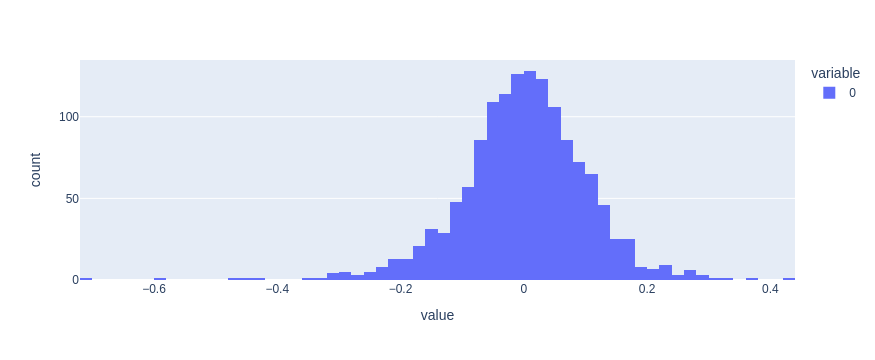

In [8]:
X = reduced.drop(["SalePrice"], axis=1).copy()
y = reduced["SalePrice"].copy()

reg = LinearRegression().fit(X, y)

pred = pd.Series(reg.predict(X))

residuals = y - pred

fig = px.histogram(residuals)
fig.show()

We see that we really have some objects which gives us abnormal residuals with respect to other data.

Also we can check new scatter 3D plot

Let's clear all objects where residuals are greater than 0.23 or smaller than -0.23

In [9]:
lin_cleared = cleared.copy()
lin_cleared = lin_cleared[(residuals <= 0.23) & (residuals >= -0.23)]
lin_deleted = cleared.copy()[(residuals > 0.23) | (residuals < -0.23)]

print("Count of deleted objects:", len(lin_deleted))

Count of deleted objects: 51


In [10]:
new_reduced = reduced.copy()[(residuals <= 0.23) & (residuals >= -0.23)]

## Scatter of cleared data

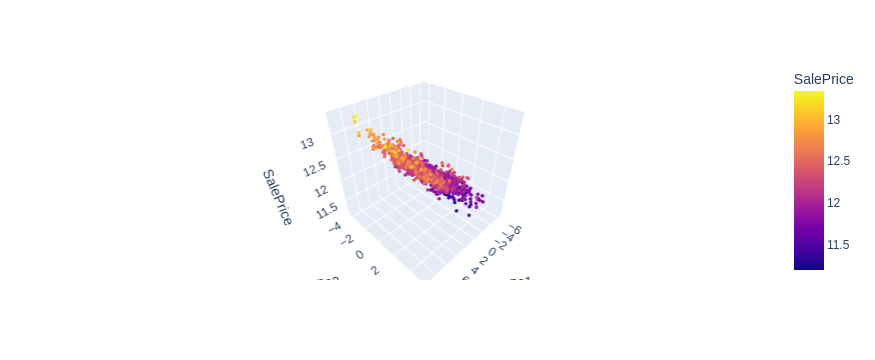

In [11]:
fig = px.scatter_3d(new_reduced, x="pc1", y="pc2", z="SalePrice", color="SalePrice")
fig.update_traces(marker_size = 2)
fig.show()

## Train/Test split and model applying

Let's take a look how Linear Regression performs on our cleared data

In [12]:
X = new_reduced.drop(["SalePrice"], axis=1).copy()
y = new_reduced["SalePrice"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

lr_reg = LinearRegression().fit(X_train, y_train)

real_y_train = np.exp(y_train)
real_y_test = np.exp(y_test)

train_pred = lr_reg.predict(X_train)
test_pred = lr_reg.predict(X_test)

print("TRAIN LOG RMSE:", root_mean_squared_error(y_train, train_pred))
print("TEST LOG RMSE:", root_mean_squared_error(y_test, test_pred))
print("." * 35)
print("TRAIN RMSE", root_mean_squared_error(real_y_train, np.exp(train_pred)))
print("TEST RMSE", root_mean_squared_error(real_y_test, np.exp(test_pred)))

TRAIN LOG RMSE: 0.08366991376522137
TEST LOG RMSE: 0.08990536148315299
...................................
TRAIN RMSE 15948.414021517825
TEST RMSE 18699.09895561385


We received much better results than using a baseline models. Let's try to make a submission

In [13]:
sub_reg = LinearRegression().fit(X, y)

pred = lr_reg.predict(X)
sub_pred = pd.Series(np.exp(sub_reg.predict(reduced_sub)))

sub_df = pd.DataFrame()
sub_df["Id"] = data_sub["Id"]
sub_df["SalePrice"] = sub_pred

sub_df.to_csv("models/PCA_linear_regression/submission.csv", index=False)

print("TRAIN LOG RMSE:", root_mean_squared_error(y, pred))

TRAIN LOG RMSE: 0.08495457280055252


These steps gave us even worse results on Kaggle than our baseline models &ndash; **0.14712**

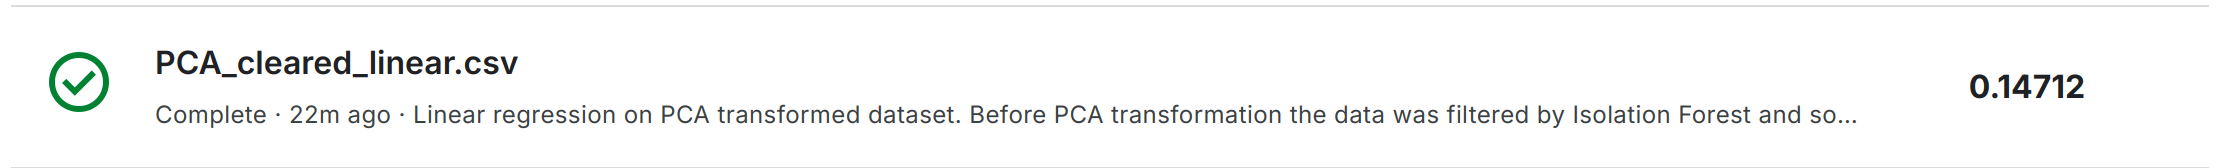

That means that we need to make some futher investigation in our data and the dependence between the features and the target isn't so easy and linear